In [1]:
import os
import argparse
import numpy as np
import cv2
from PIL import Image
import sys
import tkinter as tk

import torch
from torch.autograd import Variable
from torchvision import transforms 
import matplotlib.cm as cm
from timeit import default_timer as timer
from bts import *
import utils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 


In [10]:
def postprocess(depth):
    depth = depth - depth.min()
    depth = (depth / depth.max()) * 255
    return depth.astype('uint8')

def load_img(args, file):
    if file.endswith('.npy'):
        img = cv2.resize(np.load(file), (args.width, args.height))
    else:
        img = cv2.resize(cv2.imread(file), (args.width, args.height))
    return img

def load_focal(args):
    if args.dataset == 'nyu': 
        focal = Variable(torch.tensor([518.8579])).to(device)  
    elif args.dataset == 'kitti':
        focal = Variable(torch.tensor([715.0873])).to(device) 
    elif args.dataset == 'diode':
        focal = Variable(torch.tensor([886.81])).to(device)
    return focal

def colorize_jet(img):
    gray = None
    if img.ndim == 2:
        gray = img.copy()
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    canvas = np.uint8(cm.jet(gray)*255)
    canvas = cv2.cvtColor(canvas, cv2.COLOR_RGBA2BGR)
    return canvas

def add_mask(dm, validity_mask): 
    MIN_DEPTH = 0.0
    MAX_DEPTH = min(300, np.percentile(dm, 99))
    depth = np.clip(dm, MIN_DEPTH, MAX_DEPTH) 
    depth[ validity_mask== 0] = 0 
    return depth

def to_color(img): 
    color = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=0.0355), cv2.COLORMAP_JET)[:,:,::-1]    
    return color

In [ ]:
path = 'test_images/realsense_test_data/'
files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(('jpg', 'jpeg', 'png'))]
img =load_img(args, files[i])
depth_path = files[i][:-4] + '_depth.npy'
depth = load_img(args, depth_path)
depth.shape

In [19]:
# read images
def read_images(args, i, ground_truth = 'diode'):
    if ground_truth == 'realsense':
        path = 'test_images/realsense'
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.startswith('_Color')]
        depth_path = files[i].replace('_Color','_Depth') 
        image = load_img(args, files[i])[:, :, ::-1]
        try:
            gt_depth = cv2.resize(cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH), (args.width, args.height))
            # gt_depth[gt_depth > 9000] = 0
        except:
            print('no ground truth, inserted other depth image') 
            gt_depth = None
            return image, gt_depth, files
        
    elif ground_truth == 'diode':
        path = 'test_images/diode'
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(('jpg','jpeg','png'))]
        depth_path =  files[i][:-4] + '_depth.npy' 
        mask_path =  files[i][:-4] + '_depth_mask.npy'  
        ## load image 
        image = load_img(args, files[i])[:, :, ::-1] 
        gt_depth = load_img(args, depth_path).squeeze()
        gt_mask  = load_img(args, mask_path)
        gt_depth = add_mask(gt_depth, gt_mask) * 1000 # change millimeter
        
    elif ground_truth == 'nyu':
        path = 'test_images/nyu_gt'
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.startswith('rgb')]
        depth_path =  files[i].replace('rgb', 'sync_depth')[:-4] + '.png'
        image = load_img(args, files[i])[:, :, ::-1]
        gt_depth = load_img(args, depth_path)
#         gt_depth = cv2.resize(cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH), (args.width, args.height))
    
    elif ground_truth == 'realsense_test':
        path = 'test_images/realsense_test_data'
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(('jpg', 'jpeg', 'png'))]
        depth_path = files[i][:-4] + '_depth.npy'
        image = load_img(args, files[i])[:, :, ::-1]
        gt_depth = load_img(args, depth_path)
        gt_depth[gt_depth > 10000] = 0
                
    else:
        path = 'test_images'
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(('png', 'jpg', 'jpeg'))]
        image = load_img(args, files[i])[:, :, ::-1]
        utils.show(image, mode='plt')
        gt_depth = None
        return image, gt_depth, files

#     gt_depth = cv2.resize(cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH), (args.width, args.height))
    utils.show(image, mode='plt') 
    return image, gt_depth, files
    

In [12]:
class Args:
    model_name = 'bts_resnet50'
    encoder = 'resnet50_bts'
    checkpoint = r'model_files/rs+diode_new/rs+diode_68640'
    dataset = 'diode'
    max_depth = 350
    bts_size = 512
    height = 416
    width =  544
    choice = 'image' # image, webcam, video
    vid_path = 'videos/indoor_test_3.mp4'

args=Args()

model_dir = os.path.dirname(args.checkpoint)
sys.path.append(model_dir)  
print('[INFO] loading model..', args.checkpoint)
model = BtsModel(args)
model = torch.nn.DataParallel(model)
checkpoint = torch.load(args.checkpoint)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)
focal = load_focal(args)
print('Done')

[INFO] loading model.. model_files/rs+diode_new/rs+diode_68640
Done


0


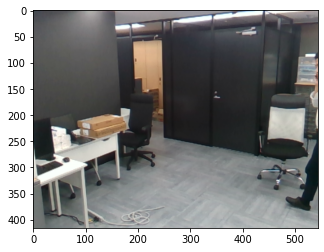

1


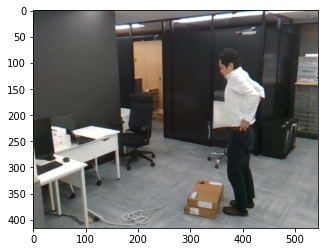

2


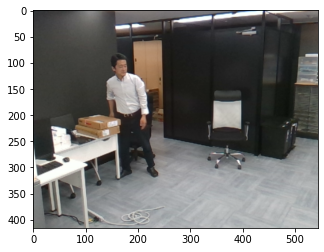

3


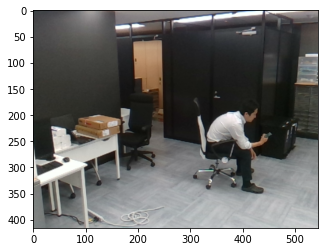

4


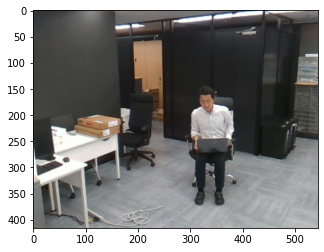

5


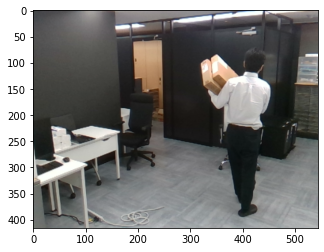

6


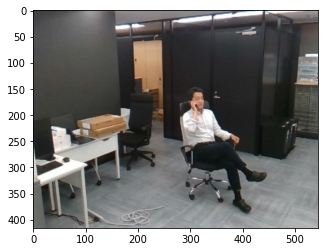

7


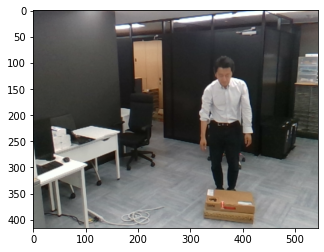

8


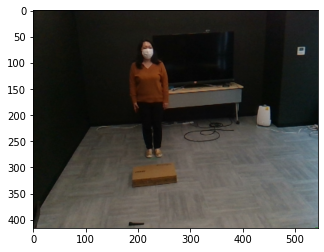

9


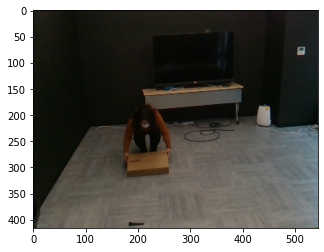

10


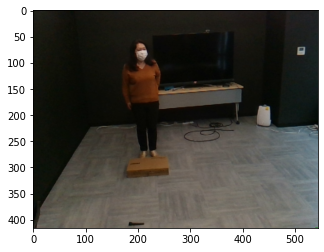

11


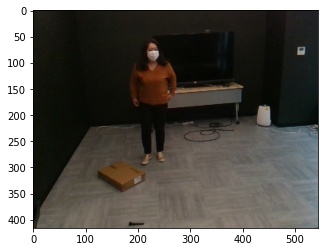

12


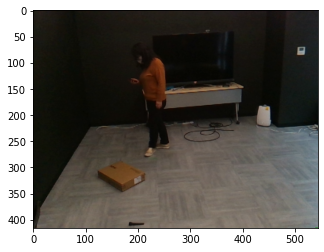

13


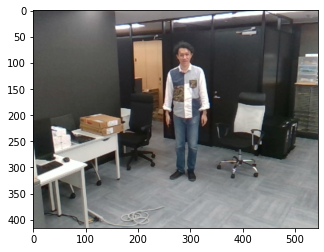

14


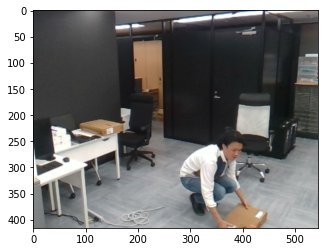

In [25]:
for i in range(15):
    try:
        print(i)
        image, gt_depth, files = read_images(args, i, ground_truth = 'realsense_test') # ground_truth [diode, nyu, realsense, ''] 
#         print(files)
    except:
        pass


In [13]:
def save_preds(path, image, gray= None):  
    cv2.imwrite(path, image) 
    if isinstance(gray, np.ndarray):
        cv2.imwrite(path[:-4] + '_gray.png', gray)
    print(path)
    
def preprocess(image):
    to_tensor = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize([0.3947, 0.3610, 0.3366], [0.1965, 0.1943, 0.2006])
#         transforms.Normalize([0.3931, 0.3582, 0.3330], [0.1933, 0.1913, 0.1982])
        ])
    tensor_img = to_tensor(image).unsqueeze(0).to(device)
    
    return tensor_img 

enter index: 10


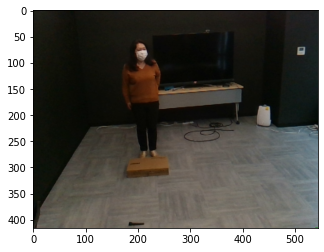

[INFO] Computing Error

silog	: 38.0849
abs_rel	: 0.3027999997138977
d1	: 0.8113
d2	: 0.8691
d3	: 0.9082


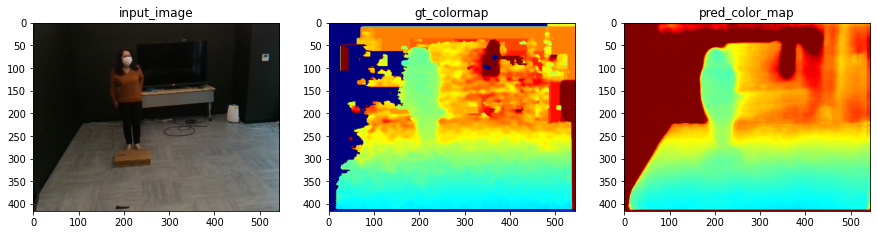

results/rs+diode_68640_results/images/lady1_1056.png


In [26]:
# images
with torch.no_grad():   
    if args.choice == 'image':
        out_path = 'results/images'
        i = int(input('enter index: '))
        image, gt_depth, files = read_images(args, i, ground_truth = 'realsense_test') # ground_truth [diode, nyu, realsense] 
        tensor_img = preprocess(Image.fromarray(image)) 
        *_, depth_est = model(tensor_img, focal)

        if args.dataset == 'kitti':
            pred_depth = depth_est.cpu().numpy().squeeze() * 256
        else:
            pred_depth = depth_est.cpu().numpy().squeeze() * 1000  
        pred_gray = postprocess(pred_depth)
        
        pred_colormap = to_color(pred_depth)
#        pred_colormap = colorize_jet(pred_gray)[:,:,::-1]
        
        out_path = os.path.join('results', os.path.basename(args.checkpoint) + '_results', 'images')
        os.makedirs(out_path, exist_ok= True)        
        save_name = os.path.join(out_path, os.path.basename(files[i]))   

        if isinstance(gt_depth, np.ndarray):
            gt_colormap = to_color(gt_depth) 
            measures = utils.compute_eval(gt_depth, pred_depth)
            ## view compare plot
            utils.compare_plot(figsize = (15,15), cmap = 'jet', input_image = image, gt_colormap= gt_colormap,  pred_color_map = pred_colormap )  
            ## distance viewer 
            root = tk.Tk()
            root.title(f"silog_loss : '{measures['silog']}' ") 
            utils.app(root, image, pred_depth , gt_depth, measures= measures  )
            root.mainloop()
            ## save image
            compare_imgs = cv2.hconcat([image[...,::-1], gt_colormap[:,:,::-1] , pred_colormap[:,:,::-1]]) 
            save_preds(save_name, compare_imgs, pred_gray)

        else:
            ## view compare plot
            utils.compare_plot(figsize = (15,15), cmap = 'gray', input_image = image, pred_depth = pred_depth,  pred_color_map = pred_colormap )  
            ## distance viewer 
            root = tk.Tk()
            root.title(f"max_depth : {args.max_depth}") 
            utils.app(root, image, pred_depth, pred_depth )
            root.mainloop()
            # save image
            compare_imgs = cv2.hconcat([image[...,::-1] , pred_colormap[:,:,::-1]]) 
            save_preds(save_name, compare_imgs, pred_gray)


In [42]:
# video inference
# args.width, args.height = 320, 320
with torch.no_grad():
#         args.vid_path = 'videos/indoor_test_1.mp4'
# #         args.vid_path = 'videos/indoor_test_3.mp4'
#         out_path = os.path.join('results', os.path.basename(args.checkpoint) + '_results', 'videos')
#         os.makedirs(out_path, exist_ok= True)

#         cap = cv2.VideoCapture(args.vid_path)
#         fps = cap.get(cv2.CAP_PROP_FPS) #  or fps = 24
#         fourcc = cv2.VideoWriter_fourcc(*'XVID')
#         video_writer = cv2.VideoWriter(os.path.join(out_path, '{}_'.format(os.path.basename(args.checkpoint)) + os.path.basename(args.vid_path)[:-4]+'.avi'), fourcc, fps, (args.width * 2, args.height)) 

        cap = cv2.VideoCapture(0)
        fps = 15
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer = cv2.VideoWriter(os.path.join(out_path, 'webcam.avi'), fourcc, fps, (args.width * 2 , args.height))

        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
        frame_count = 0
        i = 0
        print("Press 'Spacebar' to switch representation")
        print("Press 's' to save current frame and predictions")
        print("Press 'ese or q' to quit.")

        while True:
            ret, image = cap.read()
            if not ret:
                break
            frame_count +=1
            image = cv2.resize(image, (args.width, args.height))
            frame = image[:, :, ::-1]
            tensor_img = preprocess(Image.fromarray(frame))

            *_, depth_est = model(tensor_img, focal)
            pred_depth = depth_est.cpu().numpy().squeeze() * 1000
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time

            curr_fps = curr_fps + 1
            if accum_time > 1:
                accum_time = accum_time - 1
                fps = "FPS: " + str(curr_fps)
                curr_fps = 0

            depth = postprocess(pred_depth)
            jet_color = colorize_jet(depth)
            rs_color = to_color(pred_depth )[:, :, ::-1]   

            cv2.putText(image , text=fps, org=(3, 15), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.50, color=(0, 0, 0), thickness=2)
 
            compare_imgs = cv2.hconcat([frame[:, :, ::-1] , rs_color])
            
            preds_display = [compare_imgs, image, rs_color, depth ]
            
            if frame_count > 0:
                video_writer.write(compare_imgs)

            cv2.imshow("Depth Prediction", preds_display[i])
            k = cv2.waitKey(1)

            if k == 32: # spacebar
                i += 1
                i = i % len(preds_display)

            elif k == ord('s'):
                print('Save')
                save_name = os.path.join(out_path , f'{os.path.basename(args.vid_path)[:-4]}_{frame_count}.png')
                save_preds(save_name, rs_color, depth)

            elif k == ord('q') or k == 27:
                break 
        cap.release()
        cv2.destroyAllWindows()  


Press 'Spacebar' to switch representation
Press 's' to save current frame and predictions
Press 'ese or q' to quit.
